In [509]:
#Загрузка необходимых библиотек и модулей
import implicit

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Детерминированные алгоритмы
from implicit.nearest_neighbours import ItemItemRecommender, CosineRecommender, TFIDFRecommender

# Метрики
from implicit.evaluation import train_test_split
from implicit.evaluation import precision_at_k, mean_average_precision_at_k, AUC_at_k, ndcg_at_k

import warnings

# Домашнее задание 2. 

# Бейзлайны и детерминированные алгоритмы item-item

[1. Бейзлайны](#part1) 

[2. Детерминированные алгоритмы](#part2) 

[3. Измерение качества](#part3) 

[4*. Улучшение бейзлайнов и ItemItem](#part4) 

## 0. Подготовка данных

### 0.1. Загрузка данных

In [510]:
data = pd.read_csv('retail_train.csv')
data.head(3)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.3,1631,1,0.0,0.0


In [511]:
data['week_no'].nunique()

95

In [512]:
users, items, interactions = data.user_id.nunique(), data.item_id.nunique(), data.shape[0]

print('# users: ', users)
print('# items: ', items)
print('# interactions: ', interactions)

# users:  2499
# items:  89051
# interactions:  2396804


In [513]:
popularity = data.groupby('item_id')['sales_value'].sum().reset_index()
popularity.describe()

,item_id,sales_value
count,8.905100e+04,89051.000000
mean,5.115772e+06,83.458481
std,5.178973e+06,1628.715079
min,2.567100e+04,0.000000
25%,9.665830e+05,3.500000
50%,1.448516e+06,10.780000
75%,9.553042e+06,46.105000
max,1.802456e+07,467993.620000


In [514]:
popularity = data.groupby('item_id')['user_id'].nunique().reset_index()
popularity.describe()

,item_id,user_id
count,8.905100e+04,89051.000000
mean,5.115772e+06,14.759767
std,5.178973e+06,45.904111
min,2.567100e+04,1.000000
25%,9.665830e+05,1.000000
50%,1.448516e+06,2.000000
75%,9.553042e+06,10.000000
max,1.802456e+07,2039.000000


**Note:**  
Еще есть данные по характеристикам товаров и пользователей. Они нам пригодятся через несколько вебинаров

In [515]:
item_features = pd.read_csv('product.csv')
item_features.head(3)

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,


In [516]:
user_features = pd.read_csv('hh_demographic.csv')
user_features.head(3)

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8


### 0.2. Train-test split

В рекомендательных системах корректнее использовать train-test split по времени, а не случайно  

In [517]:
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

In [518]:
data_train.shape[0], data_test.shape[0]

(2278490, 118314)

## 1. Бейзлайны <a class="anchor" id="part1"></a><center>

Создадим датафрейм с покупками юзеров на тестовом датасете (последние 3 недели)

In [519]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(3)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107..."


In [520]:
test_users = result.shape[0]
new_test_users = len(set(data_test['user_id']) - set(data_train['user_id']))

print('В тестовом дата сете {} юзеров'.format(test_users))
print('В тестовом дата сете {} новых юзеров'.format(new_test_users))

В тестовом дата сете 2042 юзеров
В тестовом дата сете 0 новых юзеров


### 1.1. Random recommendation

In [521]:
def random_recommendation(items, n=5):
    """Случайные рекоммендации"""
    
    items = np.array(items)
    recs = np.random.choice(items, size=n, replace=False)
    
    return recs.tolist()

In [522]:
%%time

items = data_train.item_id.unique()

result['random_recommendation'] = result['user_id'].apply(lambda x: random_recommendation(items, n=5))

result.head(2)

Wall time: 3.4 s


,user_id,actual,random_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[10355640, 1094744, 1096475, 1053612, 900548]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1088724, 836090, 1091472, 888570, 898494]"


### 1.2. Popularity-based recommendation

In [523]:
def popularity_recommendation(data, n=5):
    """Топ-n популярных товаров"""
    
    popular = data.groupby('item_id')['sales_value'].sum().reset_index()
    popular.sort_values('sales_value', ascending=False, inplace=True)
    
    recs = popular.head(n).item_id
    
    return recs.tolist()

In [524]:
%%time

# Можно так делать, так как рекомендация не зависит от юзера
popular_recs = popularity_recommendation(data_train, n=5)

result['popular_recommendation'] = result['user_id'].apply(lambda x: popular_recs)
result.head(2)

Wall time: 121 ms


,user_id,actual,random_recommendation,popular_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[10355640, 1094744, 1096475, 1053612, 900548]","[6534178, 6533889, 1029743, 6534166, 1082185]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1088724, 836090, 1091472, 888570, 898494]","[6534178, 6533889, 1029743, 6534166, 1082185]"


### 1.3. Weighted random recommender

In [525]:
def weighted_random_recommendation_1(data, n=5):
    '''
    вес -- выручка от товара
    '''
    #считаем выручку от каждой покупки
    items_probabilities = pd.DataFrame({'item_id' : data['item_id'], 
                                       'item_revenue': data['quantity'] * data['sales_value']})
    
    #считаем выручку от каждого товара
    items_probabilities = items_probabilities.groupby('item_id')['item_revenue'].sum().reset_index()
    
    #считаем вероятность по каждому товару
    items_probabilities['probability'] = items_probabilities['item_revenue'] / items_probabilities['item_revenue'].sum()
    
    items = items_probabilities['item_id']
    
    prob = items_probabilities['probability']
    
    recs = np.random.choice(items, size=n, replace=False, p = prob)
    
    return recs.tolist()

def weighted_random_recommendation_2(data, n=5):
    '''
    вес -- log_2(выручка от товара)
    '''
    #считаем выручку от каждой покупки
    items_probabilities = pd.DataFrame({'item_id' : data['item_id'], 
                                       'item_revenue': data['quantity'] * data['sales_value']})
    
    #считаем выручку от каждого товара
    items_probabilities = items_probabilities.groupby('item_id')['item_revenue'].sum().reset_index()
    
    #оставляем только те товары, где выручка > 1
    items_probabilities = items_probabilities.loc[items_probabilities["item_revenue"] >= 1]
    
    #считаем логарифмы от выручки по каждому товару
    items_probabilities['log_revenue'] = [np.log(revenue) for revenue in items_probabilities['item_revenue'].values]
    
    #считаем вероятности по каждому товару
    items_probabilities['probability'] = items_probabilities['log_revenue'] / items_probabilities['log_revenue'].sum()
    
    items = items_probabilities['item_id']
    
    prob = items_probabilities['probability']
    
    recs = np.random.choice(items, size=n, replace=False, p = prob)
    
    return recs.tolist()

In [526]:
weighted_random_recs_1 = weighted_random_recommendation_1(data_train, n=5)
weighted_random_recs_2 = weighted_random_recommendation_2(data_train, n=5)

result['weighted_random_recommendation_1'] = result['user_id'].apply(lambda x: weighted_random_recs_1)
result['weighted_random_recommendation_2'] = result['user_id'].apply(lambda x: weighted_random_recs_2)

result.head(2)

,user_id,actual,random_recommendation,popular_recommendation,weighted_random_recommendation_1,weighted_random_recommendation_2
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[10355640, 1094744, 1096475, 1053612, 900548]","[6534178, 6533889, 1029743, 6534166, 1082185]","[397896, 6534178, 1404121, 6533889, 6544236]","[9831808, 1111883, 5668996, 6407655, 6773204]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1088724, 836090, 1091472, 888570, 898494]","[6534178, 6533889, 1029743, 6534166, 1082185]","[397896, 6534178, 1404121, 6533889, 6544236]","[9831808, 1111883, 5668996, 6407655, 6773204]"


**Вывод:** бейзлайны фиксируют базовое качество, могут быть фильтрами, иногда бейзлайны лучше ML-модели.

## 2. Детерминированные алгоритмы <a class="anchor" id="part2"></a><center>

Предсказывают числа user-item матрицы

### 2.1. Item-Item Recommender / ItemKNN

Матрицы user-item не взвешивается, просто применяется kNN

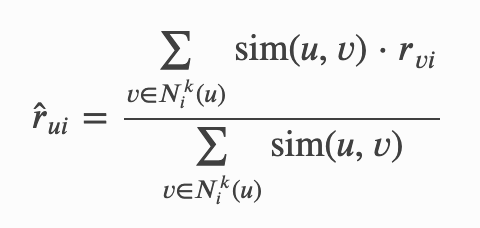

*Шаг 1:* Ищем K ближайших товаров к товару  
*Шаг 2*: predict "скора" товара = среднему "скору" этого товара у его соседей  
*Шаг 3*: Сортируем товары по убыванию predict-ов score и берем топ-k

In [527]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

popularity.head()

,item_id,n_sold
0,25671,6
1,26081,1
2,26093,1
3,26190,1
4,26355,2


In [528]:
top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [529]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [530]:
#Построение user-item матрицы
user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity',
                                  aggfunc='sum', 
                                  fill_value=0
                                 )

user_item_matrix[user_item_matrix > 0] = 1 # так как в итоге хотим предсказать 
user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат sparse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

In [531]:
#размер матрицы
user_item_matrix.shape

(2499, 5001)

In [532]:
#разреженность матрицы
user_item_matrix.sum().sum() / (user_item_matrix.shape[0] * user_item_matrix.shape[1]) * 100

5.3263136888428635

In [533]:
#создем фиктивные id для товаров и юзеров
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

Создание и обучение модели ItemItemRecommender

In [534]:
%%time

#инициализируем модель
model = ItemItemRecommender(K=5, num_threads=4) # K - кол-во билжайших соседей

#обучение модели
model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

#получение рекондаций для конкретного юзера
recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=[itemid_to_id[999999]], #отфильтровываем фиктивный id 
                        recalculate_user=False)


Wall time: 729 ms


In [535]:
#полученные рекомендации (id товаров в матрице, score)
recs

[(3408, 71827.0),
 (2148, 57814.0),
 (3947, 16876.0),
 (3587, 14102.0),
 (2307, 12312.0)]

In [536]:
#реальные id товаров
[id_to_itemid[rec[0]] for rec in recs]

[1082185, 981760, 1127831, 1098066, 995242]

In [537]:
%%time

result['itemitem'] = result['user_id'].apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], #отфильтровываем фиктивный id 
                                    recalculate_user=True)])

Wall time: 57.9 ms


In [538]:
result.head(3)

,user_id,actual,random_recommendation,popular_recommendation,weighted_random_recommendation_1,weighted_random_recommendation_2,itemitem
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[10355640, 1094744, 1096475, 1053612, 900548]","[6534178, 6533889, 1029743, 6534166, 1082185]","[397896, 6534178, 1404121, 6533889, 6544236]","[9831808, 1111883, 5668996, 6407655, 6773204]","[1082185, 981760, 1127831, 995242, 1098066]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1088724, 836090, 1091472, 888570, 898494]","[6534178, 6533889, 1029743, 6534166, 1082185]","[397896, 6534178, 1404121, 6533889, 6544236]","[9831808, 1111883, 5668996, 6407655, 6773204]","[1082185, 981760, 1098066, 995242, 826249]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[826578, 10457040, 8249365, 8355257, 838752]","[6534178, 6533889, 1029743, 6534166, 1082185]","[397896, 6534178, 1404121, 6533889, 6544236]","[9831808, 1111883, 5668996, 6407655, 6773204]","[1082185, 981760, 1127831, 995242, 1098066]"


### 2.2. Косинусное сходство и CosineRecommender

Производится взвешивание user-item матрицы, чтобы расстояния между векторами товаров считались как косинусное расстояние (а не евклидово)

In [539]:
%%time

#создание модели и получение рекомендаций
model = CosineRecommender(K=5, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(), 
          show_progress=True)

recs = model.recommend(userid=userid_to_id[1], 
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, 
                        filter_already_liked_items=False, 
                        filter_items=[itemid_to_id[999999]], #отфильтровываем фиктивный id 
                        recalculate_user=False)


Wall time: 716 ms


In [540]:
#реальные id рекомендованных товаров
[id_to_itemid[rec[0]] for rec in recs]

[1082185, 981760, 1127831, 1098066, 961554]

In [541]:
%%time

result['cosine'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], #отфильтровываем фиктивный id 
                                    recalculate_user=True)])

Wall time: 71 ms


In [542]:
result.head(3)

,user_id,actual,random_recommendation,popular_recommendation,weighted_random_recommendation_1,weighted_random_recommendation_2,itemitem,cosine
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[10355640, 1094744, 1096475, 1053612, 900548]","[6534178, 6533889, 1029743, 6534166, 1082185]","[397896, 6534178, 1404121, 6533889, 6544236]","[9831808, 1111883, 5668996, 6407655, 6773204]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1088724, 836090, 1091472, 888570, 898494]","[6534178, 6533889, 1029743, 6534166, 1082185]","[397896, 6534178, 1404121, 6533889, 6544236]","[9831808, 1111883, 5668996, 6407655, 6773204]","[1082185, 981760, 1098066, 995242, 826249]","[1082185, 1098066, 981760, 826249, 883404]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[826578, 10457040, 8249365, 8355257, 838752]","[6534178, 6533889, 1029743, 6534166, 1082185]","[397896, 6534178, 1404121, 6533889, 6544236]","[9831808, 1111883, 5668996, 6407655, 6773204]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]"


### 2.3. TF-IDF взвешивание и TFIDFRecommender

В качестве взвешивания user-item матрицы используются следующие веса. Матрица нормируется и к ней применяется kNN.

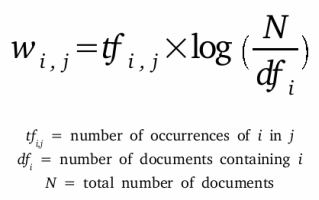

Если 2 юзера оба купили очень популярный товар, то это еще не значит,что они похожи   
Если 2 юзера оба купили редкий товар, то они похожи

Занижаем вес популярных товаров при расчете расстояний между пользователями

In [543]:
%%time

#создание модели и получение рекомендаций
model = TFIDFRecommender(K=5, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(), 
          show_progress=True)

recs = model.recommend(userid=userid_to_id[1], 
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, 
                        filter_already_liked_items=False, 
                        filter_items=[itemid_to_id[999999]], #отфильтровываем фиктивный id 
                        recalculate_user=False)


Wall time: 735 ms


In [544]:
#реальные id рекомендованных товаров
[id_to_itemid[rec[0]] for rec in recs]

[1082185, 981760, 1127831, 1098066, 961554]

In [545]:
%%time

result['tfidf'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], #отфильтровываем фиктивный id 
                                    recalculate_user=True)])

Wall time: 73.8 ms


In [546]:
result.head(3)

,user_id,actual,random_recommendation,popular_recommendation,weighted_random_recommendation_1,weighted_random_recommendation_2,itemitem,cosine,tfidf
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[10355640, 1094744, 1096475, 1053612, 900548]","[6534178, 6533889, 1029743, 6534166, 1082185]","[397896, 6534178, 1404121, 6533889, 6544236]","[9831808, 1111883, 5668996, 6407655, 6773204]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 981760, 1127831, 1098066, 961554]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1088724, 836090, 1091472, 888570, 898494]","[6534178, 6533889, 1029743, 6534166, 1082185]","[397896, 6534178, 1404121, 6533889, 6544236]","[9831808, 1111883, 5668996, 6407655, 6773204]","[1082185, 981760, 1098066, 995242, 826249]","[1082185, 1098066, 981760, 826249, 883404]","[1082185, 981760, 1098066, 826249, 883404]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[826578, 10457040, 8249365, 8355257, 838752]","[6534178, 6533889, 1029743, 6534166, 1082185]","[397896, 6534178, 1404121, 6533889, 6544236]","[9831808, 1111883, 5668996, 6407655, 6773204]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 981760, 1127831, 878996, 961554]"


### 2.4. Трюк

In [547]:
%%time
#рекомендация среди своих покупок
#считаем что ближайший сосед к пользователю -- он сам и рекомендуем ему товары, которые он уже покупал
model = ItemItemRecommender(K=1, num_threads=4) # K - кол-во билжайших соседей


model.fit(csr_matrix(user_item_matrix).T.tocsr(), 
          show_progress=True)

recs = model.recommend(userid=userid_to_id[1], 
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, 
                        filter_already_liked_items=False, 
                        filter_items=[itemid_to_id[999999]], #отфильтровываем фиктивный id 
                        recalculate_user=False)


Wall time: 700 ms


In [548]:
#реальные id рекомендованных товаров
[id_to_itemid[rec[0]] for rec in recs]

[1082185, 1029743, 995785, 1004906, 1081177]

In [549]:
%%time

result['own_purchases'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=False)])

Wall time: 44 ms


In [550]:
result.head(3)

,user_id,actual,random_recommendation,popular_recommendation,weighted_random_recommendation_1,weighted_random_recommendation_2,itemitem,cosine,tfidf,own_purchases
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[10355640, 1094744, 1096475, 1053612, 900548]","[6534178, 6533889, 1029743, 6534166, 1082185]","[397896, 6534178, 1404121, 6533889, 6544236]","[9831808, 1111883, 5668996, 6407655, 6773204]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 1029743, 995785, 1004906, 1081177]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1088724, 836090, 1091472, 888570, 898494]","[6534178, 6533889, 1029743, 6534166, 1082185]","[397896, 6534178, 1404121, 6533889, 6544236]","[9831808, 1111883, 5668996, 6407655, 6773204]","[1082185, 981760, 1098066, 995242, 826249]","[1082185, 1098066, 981760, 826249, 883404]","[1082185, 981760, 1098066, 826249, 883404]","[1082185, 1098066, 6534178, 1127831, 1068719]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[826578, 10457040, 8249365, 8355257, 838752]","[6534178, 6533889, 1029743, 6534166, 1082185]","[397896, 6534178, 1404121, 6533889, 6544236]","[9831808, 1111883, 5668996, 6407655, 6773204]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 981760, 1127831, 878996, 961554]","[1082185, 1029743, 6534178, 1127831, 995785]"


## 3. Измерение качества<a class="anchor" id="part3"></a><center>

### 3.1. Функции подсчета ML-метрик

In [551]:
import os, sys
    
#встроенные функции
from metrics import precision_at_k, recall_at_k

#функции из домашнего задания 1
def precisionatk(recommended_list, bought_list, k=5):
    
    recommended_list = np.array(recommended_list[:k])
    
    bought_list = np.array(bought_list)
        
    flags = np.isin(recommended_list, bought_list) * 1
    
    precision = flags.sum() / len(recommended_list) 
        
    return precision

def recallatk(recommended_list, bought_list, k=5):
     
    recommended_list = np.array(recommended_list[:k])
    
    bought_list = np.array(bought_list)
            
    flags = np.isin(bought_list, recommended_list) * 1
    
    recall = flags.sum() / len(bought_list)
    
    return recall

In [552]:
result.head(2)

,user_id,actual,random_recommendation,popular_recommendation,weighted_random_recommendation_1,weighted_random_recommendation_2,itemitem,cosine,tfidf,own_purchases
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[10355640, 1094744, 1096475, 1053612, 900548]","[6534178, 6533889, 1029743, 6534166, 1082185]","[397896, 6534178, 1404121, 6533889, 6544236]","[9831808, 1111883, 5668996, 6407655, 6773204]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 1029743, 995785, 1004906, 1081177]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1088724, 836090, 1091472, 888570, 898494]","[6534178, 6533889, 1029743, 6534166, 1082185]","[397896, 6534178, 1404121, 6533889, 6544236]","[9831808, 1111883, 5668996, 6407655, 6773204]","[1082185, 981760, 1098066, 995242, 826249]","[1082185, 1098066, 981760, 826249, 883404]","[1082185, 981760, 1098066, 826249, 883404]","[1082185, 1098066, 6534178, 1127831, 1068719]"


### 3.1. Сводная таблица метрик

In [553]:
metrics = [precision_at_k, precisionatk, recall_at_k, recallatk]
name_cols = result.columns.tolist()[2:]
metric_score = []
for metric in metrics:
    metric_score.append([result.apply(lambda row: metric(row[name_col], row['actual'], 5), axis=1).mean() for name_col in name_cols])  

C:\Users\BazhanovaEN\Recommendation_systems\metrics.py:20: RuntimeWarning: invalid value encountered in long_scalars
  return flags.sum() / len(recommended_list)
<ipython-input-551-2228efd54c90>:15: RuntimeWarning: invalid value encountered in long_scalars
  precision = flags.sum() / len(recommended_list)


In [554]:
result_metrics = pd.DataFrame({'precision_at_k': metric_score[0], 
              'precision_at_k (ДЗ-1)': metric_score[1],
              'recall_at_k': metric_score[2],
              'recall_at_k (ДЗ-1)': metric_score[3]}, 
             index=['random_recommendation','popular_recommendation',
                    'weighted_random_recommendation_1','weighted_random_recommendation_2',
                    'itemitem','cosine','tfidf','own_purchases'])

result_metrics

,precision_at_k,precision_at_k (ДЗ-1),recall_at_k,recall_at_k (ДЗ-1)
random_recommendation,0.001077,0.001077,0.000070,0.000070
popular_recommendation,0.155240,0.155240,0.024996,0.024996
weighted_random_recommendation_1,0.043585,0.043585,0.011295,0.011295
weighted_random_recommendation_2,0.000392,0.000392,0.000043,0.000043
itemitem,0.151322,0.151322,0.018148,0.018148
cosine,0.155436,0.155436,0.017485,0.017485
tfidf,0.161214,0.161214,0.018664,0.018664
own_purchases,0.202016,0.202016,0.029304,0.029304


**Вывод:**
1) написанные в ДЗ-1 функции подсчета метрик работают правильно, 

2) лучшая метрика у tfidf.

## 4*. Улучшение бейзлайнов и ItemItem <a class="anchor" id="part4"></a><center>

### 4.1. Подсчет бейзлайнов на топ-5000 товаров

In [555]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

#id top-5000 популярных товаров
top_5000 = popularity.sort_values('n_sold', ascending=False).head(5001).item_id.tolist()
top_5000.remove(999999)
len(top_5000)

5000

In [556]:
baselines = data_test.groupby('user_id')['item_id'].unique().reset_index()
baselines.columns=['user_id', 'actual']
baselines.head(3)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107..."


#### 4.1.1. random_recommendation

In [557]:
#random_recommendation
items = top_5000

baselines['random_recommendation'] = baselines['user_id'].apply(lambda x: random_recommendation(items, n=5))

baselines.head(3)

,user_id,actual,random_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1070845, 1077373, 15926712, 915874, 941883]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1102185, 1001646, 852486, 1137304, 1047076]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[12132685, 1041157, 965543, 963502, 823915]"


#### 4.1.2. popularity-based recommendation

In [558]:
%%time
# собираем датасет с id товарами из top-5000
popular_recs = popularity_recommendation(data_train.loc[data_train['item_id'].isin(top_5000)], n=5)

baselines['popular_recommendation'] = baselines['user_id'].apply(lambda x: popular_recs)

baselines.head(3)

Wall time: 388 ms


,user_id,actual,random_recommendation,popular_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1070845, 1077373, 15926712, 915874, 941883]","[6534178, 6533889, 1029743, 6534166, 1082185]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1102185, 1001646, 852486, 1137304, 1047076]","[6534178, 6533889, 1029743, 6534166, 1082185]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[12132685, 1041157, 965543, 963502, 823915]","[6534178, 6533889, 1029743, 6534166, 1082185]"


#### 4.1.3. weighted_random_recommendations

In [559]:
#weighted_random_recommendations
weighted_random_recs_1 = weighted_random_recommendation_1(data_train.loc[data_train['item_id'].isin(top_5000)], n=5)
weighted_random_recs_2 = weighted_random_recommendation_2(data_train.loc[data_train['item_id'].isin(top_5000)], n=5)

baselines['weighted_random_recommendation_1'] = baselines['user_id'].apply(lambda x: weighted_random_recs_1)
baselines['weighted_random_recommendation_2'] = baselines['user_id'].apply(lambda x: weighted_random_recs_2)

baselines.head(3)

,user_id,actual,random_recommendation,popular_recommendation,weighted_random_recommendation_1,weighted_random_recommendation_2
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1070845, 1077373, 15926712, 915874, 941883]","[6534178, 6533889, 1029743, 6534166, 1082185]","[6534178, 6534166, 6533889, 6544236, 5703832]","[12185599, 963336, 5565664, 891141, 1054654]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1102185, 1001646, 852486, 1137304, 1047076]","[6534178, 6533889, 1029743, 6534166, 1082185]","[6534178, 6534166, 6533889, 6544236, 5703832]","[12185599, 963336, 5565664, 891141, 1054654]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[12132685, 1041157, 965543, 963502, 823915]","[6534178, 6533889, 1029743, 6534166, 1082185]","[6534178, 6534166, 6533889, 6544236, 5703832]","[12185599, 963336, 5565664, 891141, 1054654]"


#### 4.1.4. Метрики качества

In [560]:
metrics = [precision_at_k, recall_at_k]
name_cols = baselines.columns.tolist()[2:]
metric_score = []
for metric in metrics:
    metric_score.append([baselines.apply(lambda row: metric(row[name_col], row['actual'], 5), axis=1).mean() for name_col in name_cols])  

In [561]:
baselines_metrics = pd.DataFrame({'precision_at_k': metric_score[0], 
              'recall_at_k': metric_score[1]},
             index=['random_recommendation','popular_recommendation',
                    'weighted_random_recommendation_1','weighted_random_recommendation_2'])
baselines_metrics

,precision_at_k,recall_at_k
random_recommendation,0.007052,0.000502
popular_recommendation,0.155240,0.024996
weighted_random_recommendation_1,0.045935,0.011941
weighted_random_recommendation_2,0.003134,0.000295


Сравним с полученным ранее результатом

In [562]:
result_metrics

,precision_at_k,precision_at_k (ДЗ-1),recall_at_k,recall_at_k (ДЗ-1)
random_recommendation,0.001077,0.001077,0.000070,0.000070
popular_recommendation,0.155240,0.155240,0.024996,0.024996
weighted_random_recommendation_1,0.043585,0.043585,0.011295,0.011295
weighted_random_recommendation_2,0.000392,0.000392,0.000043,0.000043
itemitem,0.151322,0.151322,0.018148,0.018148
cosine,0.155436,0.155436,0.017485,0.017485
tfidf,0.161214,0.161214,0.018664,0.018664
own_purchases,0.202016,0.202016,0.029304,0.029304


**Вывод:** 
1) подсчет безлайнов на top-5000 товаров имеет лучшие ML-метрики.

2) лучшая метрика у бейзлайна popular_recommendation, для которого нет разницы: считать его на всем множестве id товаров или только среди top-5000 (последнее вычислительно удобнее).

### 4.2. ItemItemRecommender c различным числом соседей

In [563]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(3)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107..."


In [564]:
def itemitem_k_rec(result, k):
    #инициализируем модель
    model = ItemItemRecommender(k, num_threads=4)

    #обучение модели
    model.fit(csr_matrix(user_item_matrix).T.tocsr())

    #получение рекондаций
    recs = result['user_id'].apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], #отфильтровываем фиктивный id 
                                    recalculate_user=True)])
    return recs

In [565]:
K = 50 #максимальное количество соседей
l = 5 #шаг
res = []
for i in range(5, K+1, l):
    res.append(itemitem_k_rec(result,i))

In [566]:
for i in range(len(res)):
    result[f'itemitem k = {(i+1)*5}'] = res[i]

In [567]:
result.head(3)

,user_id,actual,itemitem k = 5,itemitem k = 10,itemitem k = 15,itemitem k = 20,itemitem k = 25,itemitem k = 30,itemitem k = 35,itemitem k = 40,itemitem k = 45,itemitem k = 50
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 995242, 840361, 1127831]","[1082185, 981760, 995242, 840361, 1127831]","[1082185, 981760, 995242, 840361, 1127831]","[1082185, 981760, 995242, 1127831, 840361]","[1082185, 981760, 995242, 1127831, 840361]","[1082185, 981760, 995242, 1127831, 840361]","[1082185, 981760, 995242, 1127831, 840361]","[1082185, 981760, 995242, 1127831, 840361]","[1082185, 981760, 995242, 1127831, 840361]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1082185, 981760, 1098066, 995242, 826249]","[1082185, 981760, 1098066, 826249, 995242]","[1082185, 981760, 1098066, 826249, 995242]","[1082185, 981760, 1098066, 826249, 995242]","[1082185, 981760, 1098066, 826249, 995242]","[1082185, 981760, 1098066, 826249, 995242]","[1082185, 981760, 1098066, 826249, 995242]","[1082185, 981760, 1098066, 826249, 995242]","[1082185, 981760, 1098066, 826249, 995242]","[1082185, 981760, 1098066, 826249, 995242]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 995242, 840361, 1127831]","[1082185, 981760, 840361, 995242, 1127831]","[1082185, 981760, 995242, 840361, 1127831]","[1082185, 981760, 995242, 1127831, 840361]","[1082185, 981760, 1127831, 995242, 840361]","[1082185, 981760, 1127831, 995242, 840361]","[1082185, 981760, 1127831, 995242, 840361]","[1082185, 981760, 1127831, 995242, 840361]","[1082185, 981760, 1127831, 995242, 840361]"


Посчитаем метрики

In [568]:
print('precision@5: ')
name_cols = result.columns.tolist()[2:]
precision = [result.apply(lambda row: precision_at_k(row[name_col], row['actual']), axis=1).mean() for name_col in name_cols]
precision_dict = dict(zip(name_cols, precision))
precision_dict

precision@5: 


{'itemitem k = 5': 0.15132223310479728,
 'itemitem k = 10': 0.16591576885406253,
 'itemitem k = 15': 0.16611165523995874,
 'itemitem k = 20': 0.1669931439764915,
 'itemitem k = 25': 0.16562193927521834,
 'itemitem k = 30': 0.16523016650342595,
 'itemitem k = 35': 0.1651322233104779,
 'itemitem k = 40': 0.1651322233104779,
 'itemitem k = 45': 0.1651322233104779,
 'itemitem k = 50': 0.1651322233104779}

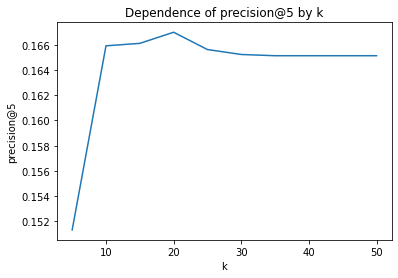

In [569]:
x = [i for i in range(5, K+1, l)]
y = [precision_dict[f'itemitem k = {i}'] for i in range(5, K+1, l)]
plt.plot(x,y)
plt.title("Dependence of precision@5 by k")
plt.xlabel("k")
plt.ylabel("precision@5")
plt.show()

**Вывод:** лучшие показатели метрики при k = 20, значит оптимальное значение k = 20

In [570]:
print('recall@5: ')
name_cols = result.columns.tolist()[2:]
recall = [result.apply(lambda row: recall_at_k(row[name_col], row['actual']), axis=1).mean() for name_col in name_cols]
recall_dict = dict(zip(name_cols, recall))
recall_dict

recall@5: 


{'itemitem k = 5': 0.018147990035538304,
 'itemitem k = 10': 0.018047049897106062,
 'itemitem k = 15': 0.018039356938960822,
 'itemitem k = 20': 0.018701981862350645,
 'itemitem k = 25': 0.01901585895928272,
 'itemitem k = 30': 0.018931553241961413,
 'itemitem k = 35': 0.01897745691581745,
 'itemitem k = 40': 0.018966559307639522,
 'itemitem k = 45': 0.018966559307639522,
 'itemitem k = 50': 0.018966559307639522}

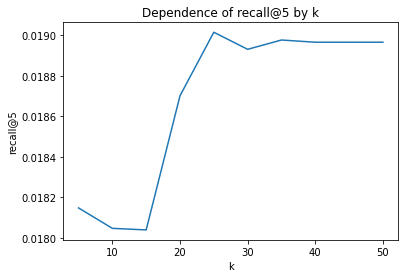

In [571]:
x = [i for i in range(5, K+1, l)]
y = [recall_dict[f'itemitem k = {i}'] for i in range(5, K+1, l)]
plt.plot(x,y)
plt.title("Dependence of recall@5 by k")
plt.xlabel("k")
plt.ylabel("recall@5")
plt.show()

**Вывод:** лучшие показатели метрики при k = 25, значит оптимальное значение k = 25